In [1]:
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

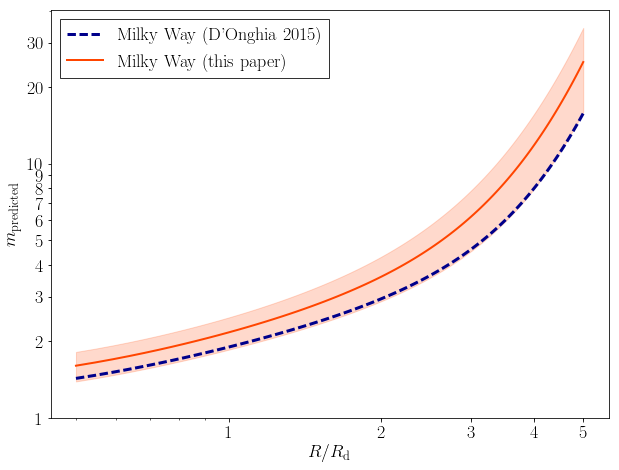

In [20]:
fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

# --- Milky way (D'Onghia model)---

M_b = [4e9] * u.Msun
delta_M_b = [0] * u.Msun

M_d = [5.9e10] * u.Msun
delta_M_d = [0.5e10] * u.Msun

a_b = [0.6] * u.kpc
delta_a_b = [0] * a_b

R_d = [2.15] * u.kpc
delta_R_d = [0.14] * u.kpc

M_hi = None
delta_M_hi = None

M_halo = [9.5e11] * u.Msun
delta_M_halo = [0.2] * M_halo

R_halo = [29.6] * u.kpc
delta_R_halo = [0.2] * R_halo

donghia_halo = TotalHalo(M_b,delta_M_b,M_d,delta_M_d,a_b,delta_a_b,
                         R_d,delta_R_d,M_hi,delta_M_hi,M_halo,delta_M_halo,
                         R_halo,delta_R_halo,1,0)

m_donghia = donghia_halo.m_equation()

_ = ax.plot(m_donghia['R']/R_d,m_donghia['m'],
             color='darkblue',lw=3,linestyle='dashed',
             label="Milky Way (D'Onghia 2015)")

our_halo = TotalHalo(M_b,delta_M_b,M_d,delta_M_d,a_b,delta_a_b,
                     R_d,delta_R_d,None,None,None,None,None,None,
                     1,0)

m_us = our_halo.m_equation()
_ = ax.plot(m_us['R']/R_d,m_us['m'],color='orangered',lw=2,
             label="Milky Way (this paper)")

_ = ax.fill_between((m_us['R']/R_d).data,(m_us['m']+m_us['error']).data,
                     (m_us['m']-m_us['error']).data,
                     color='orangered',alpha=0.2)


_ = ax.legend(edgecolor='k',fancybox=False,loc='upper left')
_ = ax.set_xlabel('$R/R_\mathrm{d}$')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

ax.set_xticks([1,2,3,4,5])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1,2,3,4,5,6,7,8,9,10,20,30])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.savefig('figures/milky_way.pdf')

In [101]:
import astropy.constants as const
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import math
import numpy as np
from scipy.special import kn as K, iv as I
from uncertainties import ufloat as uf, unumpy as unp

class TotalHalo():
    
    def __init__(self,M_b,delta_M_b,M_d,delta_M_d,a_b,delta_a_b,
                 R_d,delta_R_d,M_hi,delta_M_hi,
                 M_halo=None,delta_M_halo=None,
                 R_halo=None,delta_R_halo=None,scale=1.5,scale_error=0.2):
        
        self.M_b = M_b.to(u.Msun)
        self.delta_M_b = delta_M_b.to(u.Msun)
        self.M_d = M_d.to(u.Msun)
        self.delta_M_d = delta_M_d.to(u.Msun)
        self.a_b = a_b.to(u.kpc)
        self.delta_a_b = delta_a_b.to(u.kpc)
        self.R_d = R_d.to(u.kpc)
        self.delta_R_d = delta_R_d.to(u.kpc)
        self.M_hi = M_hi.to(u.Msun) if M_hi is not None else None
        self.delta_M_hi = delta_M_hi.to(u.Msun) if delta_M_hi is not None else None
        self.M_halo = M_halo
        self.delta_M_halo= delta_M_halo
        self.R_halo = R_halo
        self.delta_R_halo = delta_R_halo
        self.scale = scale
        self.scale_error = scale_error
        
        H0 = 70 * u.km/u.s/u.Mpc
        rho_crit = (3 * H0**2) / (8*math.pi*const.G)
        self.rho_crit = rho_crit.to(u.kg/u.m**3)
        
    def bulge_mass(self):
        return nda(self.M_b,sdu(self.delta_M_b))
    
    def disc_mass(self,hi=False):
        M_disc = nda(self.M_d,sdu(self.delta_M_d))
        if (hi is False) | (self.M_hi is None):
            return M_disc
        else:
            M_hi = nda(self.M_hi,sdu(self.delta_M_hi))
            M_tot = M_disc.add(M_hi)
            return M_tot
    
    def stellar_mass(self,hi=True):
        return self.disc_mass(hi).add(self.bulge_mass())
        
    def halo_mass(self,alpha=-0.5,alpha_upper=-0.475,alpha_lower=-0.575,
                  beta=0,logx0=10.4,gamma=1,
                  logy0=1.61,logy0_lower=1.49,logy0_upper=1.75):
        if self.M_halo is not None:
            return nda(self.M_halo,sdu(self.delta_M_halo))
        
        else:
            stellar_mass = unp.uarray(self.stellar_mass(hi=False).data,
                                       self.stellar_mass(hi=False).uncertainty.array)
        
            alpha = uf(alpha,np.max([alpha_upper-alpha,alpha-alpha_lower]))
            beta = uf(beta,0)
            x0 = uf(10**logx0,0)
            gamma = uf(gamma,0)
            y0 = uf(10**logy0,np.max([10**logy0_upper-10**logy0,
                                      10**logy0-10**logy0_lower]))
    
            a = y0 * (stellar_mass/x0)**alpha
            b = 1/2 + 1/2*((stellar_mass/x0)**gamma)
            c = (beta-alpha)/gamma
            y = a * b**c
            halo_mass = y * stellar_mass
            masses = [halo_mass[i].nominal_value for i in range(len(halo_mass))]
            uncertainties = [halo_mass[i].std_dev for i in range(len(halo_mass))]
            
            return nda(masses,sdu(uncertainties),unit=u.Msun)
    
    # --- Now for the sizes ---
    def bulge_scale_length(self):
        scale_factor = nda(self.scale,sdu(self.scale_error))
        r_b = nda(self.a_b,sdu(self.delta_a_b))
        r_b_mod = r_b.divide(scale_factor)
        return r_b.divide(scale_factor)
        
    def halo_scale_length(self,return_r200=False):
        if self.R_halo is not None:
            return nda(self.R_halo,sdu(self.delta_R_halo))
        else:
            h = 0.7
            K = 3 / (4*np.pi*200*self.rho_crit)
            M200 = self.halo_mass()
            M200_value = M200.data * (u.Msun)
            M200_error = M200.uncertainty.array * (u.Msun)
            logc200 = (0.905 - 0.101 * np.log10(M200_value/(10**12 * h**(-1) * u.Msun)))
            c200 = 10**logc200
            r200 = (K*(M200_value))**(1/3)
            r200 = r200.to(u.kpc)
            r200_error = (1/3) * r200 * M200_error/M200_value
            r_s = nda(r200,sdu(r200_error))
            if return_r200 is True:
                return r_s
            else:    
                return r_s.divide(c200)
    
    def hi_scale_length(self,m=1.87,m_error=0.03,c=7.2,c_error=0.03,
                        k=0.19,k_error=0.03): # Wang+14, Lelli+16
        
        m_param = uf(m,m_error)
        c_param = uf(c,c_error)
        k_param = uf(k,k_error)
        hi_mass = unp.uarray(self.M_hi.value,self.delta_M_hi.value)
        loghimass = unp.log10(hi_mass)
        logr_hi = (loghimass - c_param) / m
        r_hi = 10**logr_hi
        r_s = k_param * r_hi
        r_ss = [r_s[i].nominal_value for i in range(len(r_s))]
        uncertainties = [r_s[i].std_dev for i in range(len(r_s))]
        return nda(r_ss,sdu(uncertainties),unit=u.kpc)
    
    def stellar_disc_scale_length(self):
        scale_factor = nda(self.scale,sdu(self.scale_error))
        r_d = nda(self.R_d,sdu(self.delta_R_d))
        r_d_mod = r_d.divide(scale_factor)
        return r_d.divide(scale_factor)
    
    def disc_scale_length(self): 
        if self.M_hi is None:
            return self.stellar_disc_scale_length()
        else:
            r_d = unp.uarray(self.stellar_disc_scale_length().data,
                            self.stellar_disc_scale_length().uncertainty.array)
            r_g = unp.uarray(self.hi_scale_length().data,
                             self.hi_scale_length().uncertainty.array)
        
            rho_d = unp.uarray(self.M_hi.value,self.delta_M_hi.value)/r_d
            rho_g = unp.uarray(self.disc_mass(hi=False).data,
                               self.disc_mass(hi=False).uncertainty.array)/r_g
        
            r_s = 1 / (unp.log((rho_d/(rho_g+rho_d)*unp.exp(1/r_g)) 
                             + (rho_g/(rho_g+rho_d)*unp.exp(1/r_d))))
            
            r_ss = [r_s[i].nominal_value for i in range(len(r_s))]
            uncertainties = [r_s[i].std_dev for i in range(len(r_s))]
            return nda(r_ss,sdu(uncertainties),unit=u.kpc)
    
    
    def m_hernquist(self,y=np.linspace(0.25,2.5,100),R=None,X=1.5):
        
        M_B = unp.uarray(self.bulge_mass().data,self.bulge_mass().uncertainty.array)
        M_D = unp.uarray(self.disc_mass().data,self.disc_mass().uncertainty.array)
        M_H = unp.uarray(self.halo_mass().data,self.halo_mass().uncertainty.array)
        a_b = unp.uarray(self.bulge_scale_length().data,
                         self.bulge_scale_length().uncertainty.array)
        R_d = unp.uarray(self.disc_scale_length().data,
                         self.disc_scale_length().uncertainty.array)
        a_h = unp.uarray(self.halo_scale_length().data,
                         self.halo_scale_length().uncertainty.array)
        if R is not None:
            y = (R/(2*R_d)).value
        else:
            R = y * 2 * R_d
        a = unp.exp(2*y)/X
        b = (M_B/M_D) * ((2*y + (3*a_b/R_d)) / (2*y + (a_b/R_d))**3)
        c = (M_H/M_D) * ((2*y + (3*a_h/R_d)) / (2*y + (a_h/R_d))**3)
        d = (y**2/2) * (3*(I(1,y)*K(0,y)) - 3*(I(0,y)*K(1,y)) + (I(1,y)*K(2,y)) - (I(2,y)*K(1,y)))
        e = (4*y) * (I(0,y)*K(0,y) - (I(1,y)*K(1,y)))
        m = a*(b + c + d + e)
        
        m_table = Table()
        m_table['m'] = [m[i].nominal_value for i in range(len(m))]
        m_table['error'] = [m[i].std_dev for i in range(len(m))]
        m_table['R'] = [R[i].nominal_value for i in range(len(R))]
        m_table['y'] = y
        return m_table
    
    def m_isothermal(self,y=np.linspace(0.25,2.5,100),R=None,X=1.5):
        
        M_B = unp.uarray(self.bulge_mass().data,self.bulge_mass().uncertainty.array)
        M_D = unp.uarray(self.disc_mass().data,self.disc_mass().uncertainty.array)
        M_H = unp.uarray(self.halo_mass().data,self.halo_mass().uncertainty.array)
        a_b = unp.uarray(self.bulge_scale_length().data,
                         self.bulge_scale_length().uncertainty.array)
        R_d = unp.uarray(self.disc_scale_length().data,
                         self.disc_scale_length().uncertainty.array)
        a_h = unp.uarray(self.halo_scale_length().data,
                         self.halo_scale_length().uncertainty.array)
        if R is not None:
            y = (R/(2*R_d)).value
        else:
            R = y * 2 * R_d
        a = unp.exp(2*y)/X
        b = (M_B/M_D) * ((2*y + (3*a_b/R_d)) / (2*y + (a_b/R_d))**3)
        c = (M_H/M_D) * (2/math.pi) * (R_d/R)**2 * ((a_h*R/(R**2+a_h**2)) 
                                                    + unp.arctan(R/a_h))
        d = (y**2/2) * (3*(I(1,y)*K(0,y)) - 3*(I(0,y)*K(1,y)) + (I(1,y)*K(2,y)) - (I(2,y)*K(1,y)))
        e = (4*y) * (I(0,y)*K(0,y) - (I(1,y)*K(1,y)))
        m = a*(b + c + d + e)
        
        m_table = Table()
        m_table['m'] = [m[i].nominal_value for i in range(len(m))]
        m_table['error'] = [m[i].std_dev for i in range(len(m))]
        m_table['R'] = [R[i].nominal_value for i in range(len(R))]
        m_table['y'] = y
        return m_table
        

In [102]:
M_b = [4e9] * u.Msun
delta_M_b = [0] * u.Msun

M_d = [5.6e10] * u.Msun
delta_M_d = [0.5e10] * u.Msun

a_b = [0.6] * u.kpc
delta_a_b = [0] * a_b

R_d = [2.15] * u.kpc
delta_R_d = [0.14] * u.kpc

M_hi = None
delta_M_hi = None

M_halo = [9.5e11] * u.Msun
delta_M_halo = [0.2] * M_halo

R_halo = [29.6] * u.kpc
delta_R_halo = [0.2] * R_halo

donghia_halo = TotalHalo(M_b,delta_M_b,M_d,delta_M_d,a_b,delta_a_b,
                         R_d,delta_R_d,M_hi,delta_M_hi,M_halo,delta_M_halo,
                         R_halo,delta_R_halo,1,0)